In [1]:
from utils import *

predictions_path = r"C:\Users\thoma\Documents\_FAIRALGOS\utk-fairness-analysis\predictions\20210915-133017_df_predictions_gender_ref.csv"

df = parse_predictions(predictions_path)

In [2]:
display(Markdown("## Fairness analysis of predictions made by the model"))

display(Markdown(f"Number of samples: {len(df)}"))
display(Markdown(f"Number of samples classified correctly: {len(df.loc[df['pred_true'] == 1])}"))
display(Markdown(f"Number of misclassified samples: {len(df.loc[df['pred_true'] == 0])}"))

## Fairness analysis of predictions made by the model

Number of samples: 7040

Number of samples classified correctly: 6267

Number of misclassified samples: 773

## Gender, race, and age distributions in the test set

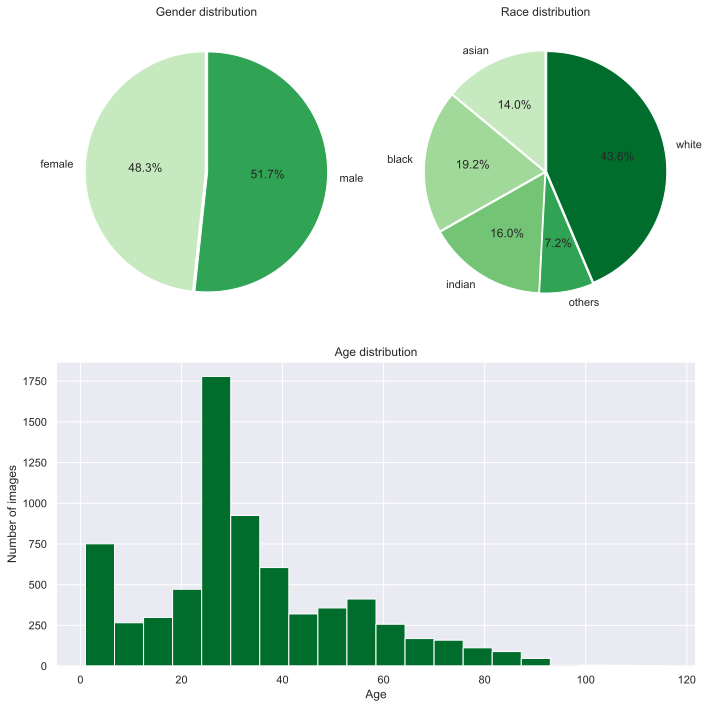

In [3]:
display(Markdown("## Gender, race, and age distributions in the test set"))

plot_distributions(convert_id_to_alias(df))

In [4]:
# rates and disparate impact for gender (manually)

male_positive = len(df.loc[(df['gender'] == 0) & (df['pred_true'] == 1)])
male_negative = len(df.loc[(df['gender'] == 0) & (df['pred_true'] == 0)])

female_positive = len(df.loc[(df['gender'] == 1) & (df['pred_true'] == 1)])
female_negative = len(df.loc[(df['gender'] == 1) & (df['pred_true'] == 0)])

mr = male_positive / (male_positive + male_negative)
fr = female_positive / (female_positive + female_negative)


print(f"Base rate male: {mr:.3f}\nBase rate female: {fr:.3f}\nDisparate impact female: {fr/mr:.3f}")

Base rate male: 0.865
Base rate female: 0.918
Disparate impact female: 1.061


In [5]:
# One hot encoding for age and race 

df_bld = df.drop(columns=['files', 'weights'])

bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
df_bld['age'] = pd.cut(df_bld['age'], bins, labels=[0,1,2,3,4,5,6])

onehot = pd.get_dummies(df_bld['gender'], prefix='gender')
df_bld = df_bld.drop(columns='gender')
df_bld = df_bld.join(onehot)
df_bld = df_bld.rename(columns={'gender_0': 'male', 'gender_1': 'female'})

onehot = pd.get_dummies(df_bld['age'], prefix='age')
df_bld = df_bld.drop(columns='age')
df_bld = df_bld.join(onehot)

onehot = pd.get_dummies(df_bld['race'], prefix='race')
df_bld = df_bld.drop(columns='race')
df_bld = df_bld.join(onehot)

df_bld

,pred_true,male,female,age_0,age_1,age_2,age_3,age_4,age_5,age_6,race_0,race_1,race_2,race_3,race_4
0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0
2,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0
3,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
4,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0
7036,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
7037,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0
7038,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0


In [6]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

group = "female"

bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_bld, label_names=['pred_true'], protected_attribute_names=[group])
bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{group: 1}], privileged_groups=[{group: 0}])

print(f"Disparate impact gender: {bld_metric.disparate_impact():.3f}")

Disparate impact gender: 1.061


In [7]:
groups = df_bld.columns.values.tolist()
groups.remove('pred_true')

metrics = {}

for group in groups:
    bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_bld, label_names=['pred_true'], protected_attribute_names=[group])
    bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{group: 1}], privileged_groups=[{group: 0}])

    metric = bld_metric.disparate_impact()
    metrics[group] = metric


metrics

{'male': 0.9420837787509534,
 'female': 1.0614767206010423,
 'age_0': 0.6895662921660395,
 'age_1': 0.9588334070574868,
 'age_2': 1.085518378614742,
 'age_3': 1.081264640121084,
 'age_4': 1.078798880568792,
 'age_5': 1.015444937468845,
 'age_6': 0.9031666826600134,
 'race_0': 1.0131810738233011,
 'race_1': 1.0284819273217558,
 'race_2': 0.9369189996367696,
 'race_3': 1.007765734930595,
 'race_4': 0.9849008420078367}

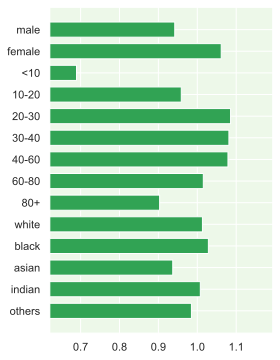

In [8]:
plot_metrics_for_all_groups(metrics)